In [96]:
import itertools
import operator
import sys
import os
import numpy as np
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from matplotlib import pyplot as plt

In [98]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=lr_sweep"
checkpoint_name = "metrics_test.json"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)

print(len(files))

220


In [99]:
def expand(idx,chunk):
  if idx == 0:
    return ["job_id={}".format(chunk)]
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  elif chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]
  return []

experiments = []
for file in files:
    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data['dir'] = os.path.dirname(file)
    data['context'] = int(data['context'])
    data['lr'] = float(data['lr'])
    experiments.append(data)

In [100]:
for experiment in experiments:
    with open(experiment['file']) as f:
        results = json.load(f)

    experiment["EM"] = results['test']["EM"]

    for k,v in results['test']["raw"]["relation_type"].items():
        experiment["breakdown_{}".format(k)] = np.mean(v)

    for k,v in results['test']["raw"]["query_type"].items():
        experiment["query_{}".format(k)] = np.mean(v)

In [101]:
results = pd.DataFrame(experiments).fillna(0)
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "EM" or col.startswith("query_") or col.startswith("breakdown_"),results.columns)}
query_cols = list(filter(lambda col: col.startswith("query_"),results.columns))
breakdown_cols = list(filter(lambda col: col.startswith("breakdown_"),results.columns))
breakdown = pd.pivot_table(results, index=["model","lr","context"],columns=["version"],aggfunc=cols)
breakdown

EM                                \
                            mean                 std             
version                     v0.4      v0.5      v0.4      v0.5   
model   lr     context                                           
t5-base 0.0006 50       0.881945       NaN  0.007675       NaN   
               100      0.900261       NaN  0.004074       NaN   
               500      0.933181       NaN  0.003833       NaN   
               1000     0.931512       NaN  0.000484       NaN   
               2000     0.928056       NaN  0.003017       NaN   
               5000     0.935971       NaN  0.013056       NaN   
               7000     0.924889       NaN  0.003555       NaN   
               10000    0.936952       NaN  0.002346       NaN   
        0.0008 50       0.885472       NaN  0.000938       NaN   
               100      0.898925       NaN  0.004783       NaN   
               500      0.927113       NaN  0.002291       NaN   
               1000     0.929950       NaN  0.004185       NaN   
               2000     0.932534       NaN  0.002496       NaN   
               5000     0.935581       NaN  0.010386       NaN   
               7000     0.925438       NaN  0.006218       NaN   
               10000    0.935113       NaN  0.001879       NaN   
        0.0010 50       0.880246       NaN  0.007640       NaN   
               100      0.902833       NaN  0.005993       NaN   
               500      0.928647  0.903868  0.002470  0.004559   
               1000     0.927612       NaN  0.003693       NaN   
               2000     0.926852  0.931324  0.005019  0.004671   
               5000     0.936816  0.914652  0.012749  0.003390   
               7000     0.923385  0.918366  0.003983  0.002642   
               10000    0.938198  0.916243  0.002526  0.006820   
        0.0020 50       0.877266       NaN  0.007341       NaN   
               100      0.897696       NaN  0.004125       NaN   
               500      0.920641       NaN  0.005637       NaN   
               1000     0.924376       NaN  0.005653       NaN   
               2000     0.923835       NaN  0.004337       NaN   
               5000     0.925906       NaN  0.010831       NaN   
               7000     0.912495       NaN  0.003864       NaN   
               10000    0.924024       NaN  0.003769       NaN   
        0.0040 50       0.780894       NaN  0.182352       NaN   
               100      0.871462       NaN  0.042004       NaN   
               500      0.896280       NaN  0.051204       NaN   
               1000     0.797762       NaN  0.194512       NaN   
               2000     0.869863       NaN  0.068828       NaN   
               5000     0.893068       NaN  0.055719       NaN   
               7000     0.828327       NaN  0.118758       NaN   
               10000    0.718231       NaN  0.200769       NaN   

                       breakdown_born_in                                \
                                    mean                 std             
version                             v0.4      v0.5      v0.4      v0.5   
model   lr     context                                                   
t5-base 0.0006 50               0.848641       NaN  0.016084       NaN   
               100              0.863988       NaN  0.013700       NaN   
               500              0.922608       NaN  0.006560       NaN   
               1000             0.919974       NaN  0.009078       NaN   
               2000             0.906155       NaN  0.010599       NaN   
               5000             0.916338       NaN  0.017105       NaN   
               7000             0.874337       NaN  0.008132       NaN   
               10000            0.916089       NaN  0.013508       NaN   
        0.0008 50               0.850344       NaN  0.004965       NaN   
               100              0.863365       NaN  0.011797       NaN   
               500              0.908760       NaN  0.008903       NaN   
               

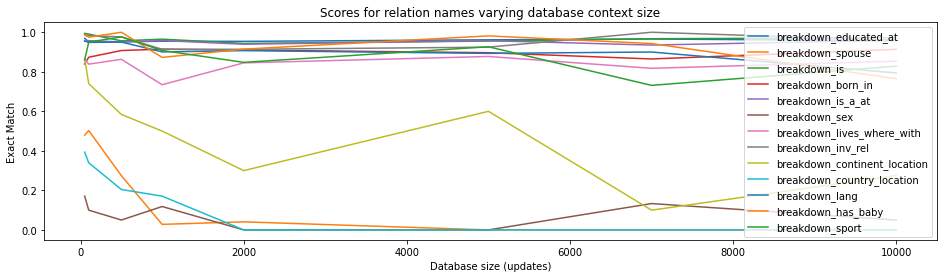

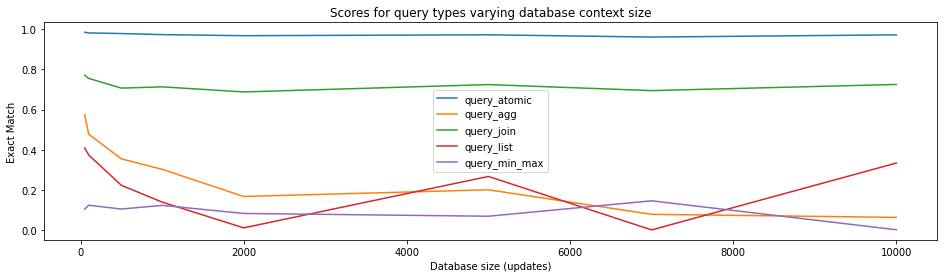

In [88]:
data_sizes = [50,100,500,1000,2000,5000,7000,1000]
plt.figure(figsize=(16,4))

a=[]
for col in breakdown_cols:
    means = breakdown[col]["mean"].T["t5-base"][1e-3].T['v0.4']
    std = breakdown[col]["std"].T["t5-base"][1e-3].T['v0.4']
    a.append(means)

    plt.plot(means)



plt.title("Scores for relation names varying database context size")
plt.xlabel("Database size (updates)")
plt.ylabel("Exact Match")
plt.legend(breakdown_cols)

plt.show()


plt.figure(figsize=(16,4))

a=[]
for col in query_cols:
    means = breakdown[col]["mean"].T["t5-base"][1e-3].T['v0.4']
    std = breakdown[col]["std"].T["t5-base"][1e-3].T['v0.4']
    a.append(means)

    plt.plot(means)



plt.title("Scores for query types varying database context size")
plt.xlabel("Database size (updates)")
plt.ylabel("Exact Match")
plt.legend(query_cols)


plt.show()


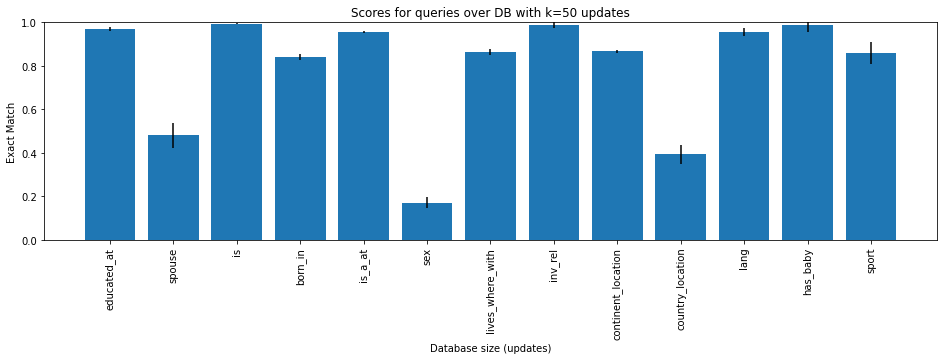

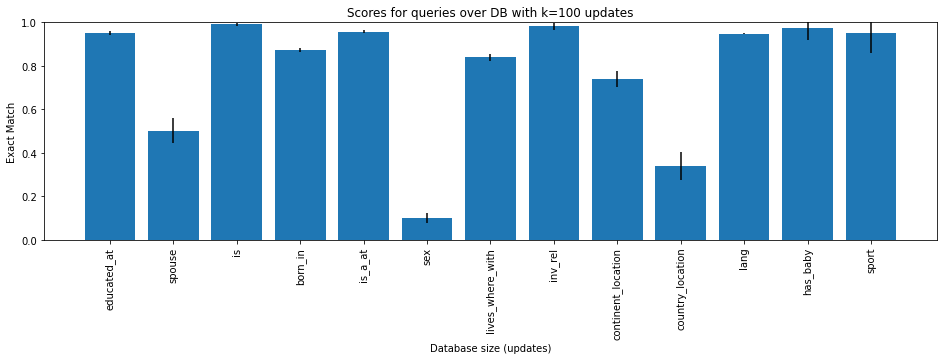

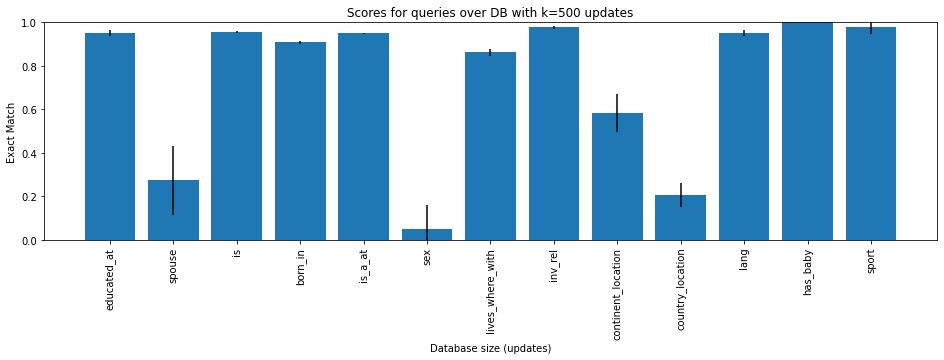

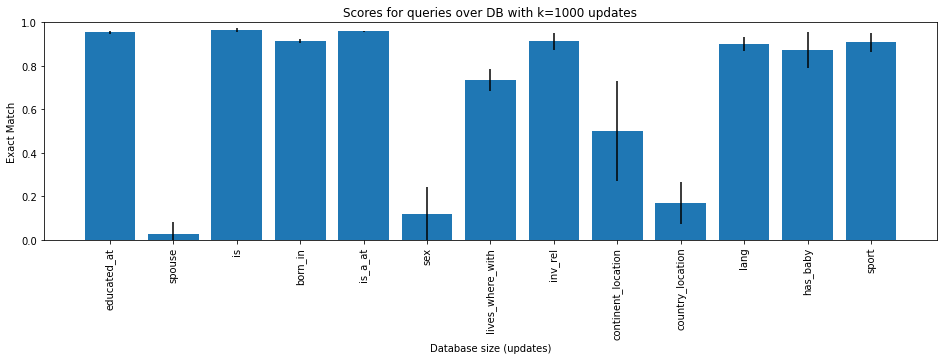

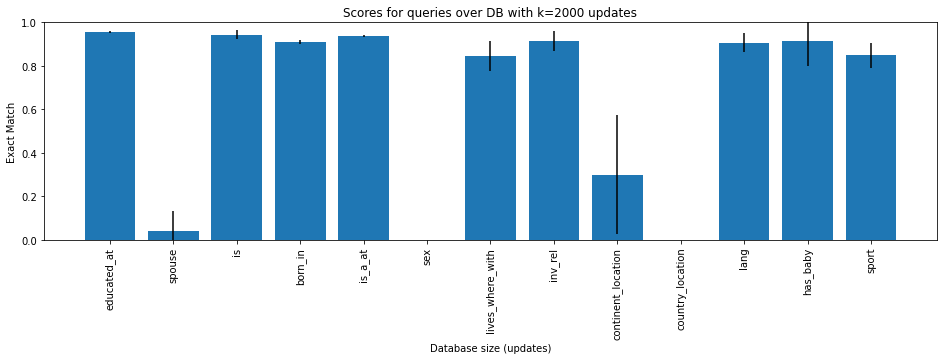

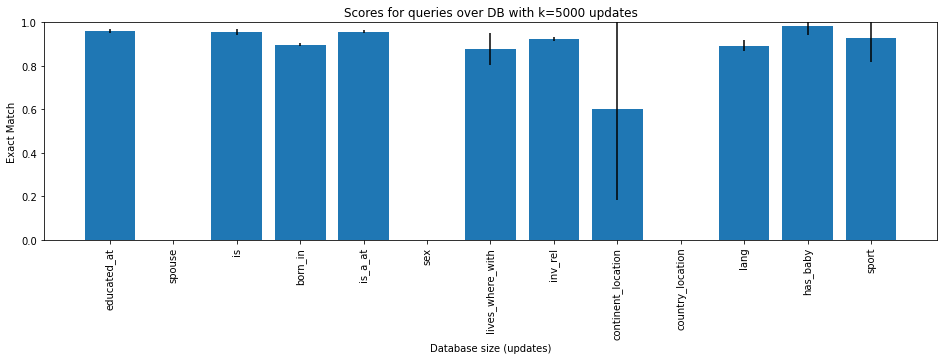

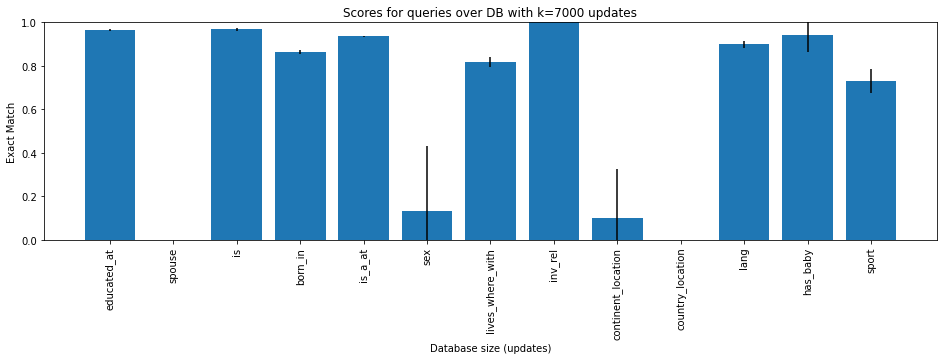

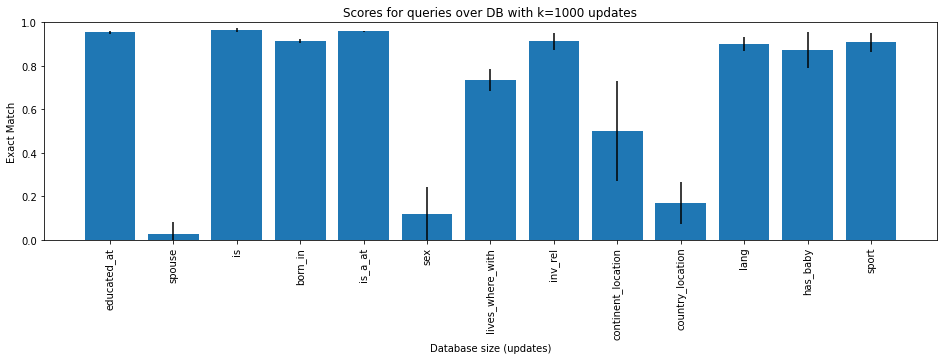

In [84]:
data_sizes = [50,100,500,1000,2000,5000,7000,1000]


a=[]
for size in data_sizes:
    plt.figure(figsize=(16,4))
    plt.title("Scores for queries over DB with k={} updates".format(size))
    plt.xlabel("Database size (updates)")
    plt.ylabel("Exact Match")
    plt.xticks(rotation=90)
    plt.ylim(0,1)
    means = [breakdown[col]["mean"].T["t5-base"][1e-3].T['v0.4'].T[size] for col in breakdown_cols]
    std = [breakdown[col]["std"].T["t5-base"][1e-3].T['v0.4'].T[size] for col in breakdown_cols]

    plt.bar([col.replace("breakdown_","") for col in breakdown_cols],means,yerr=std)



    plt.show()



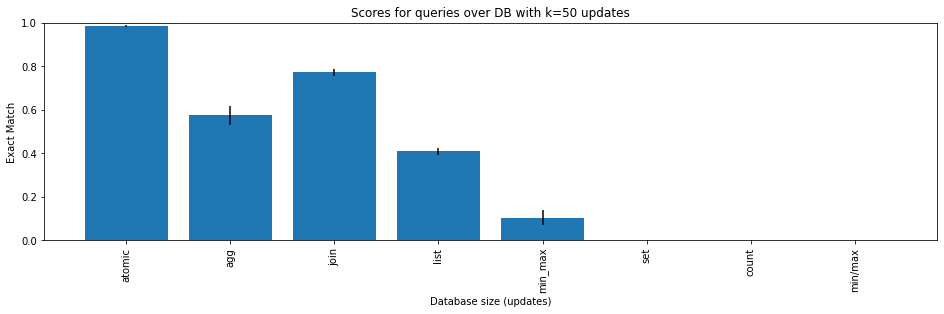

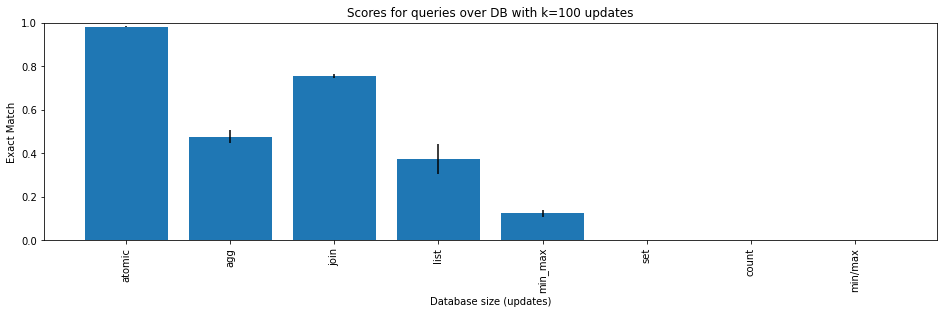

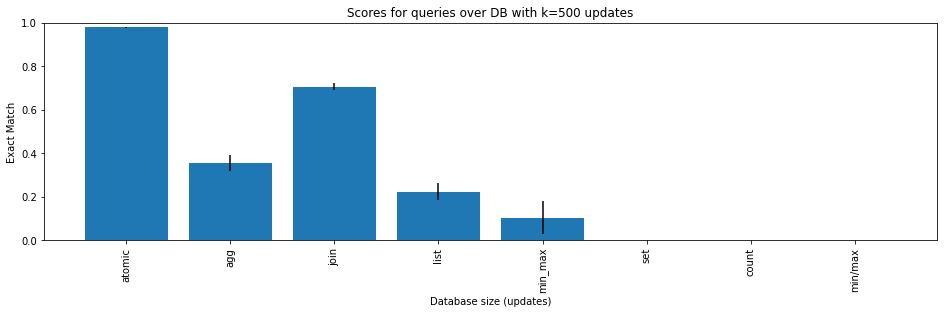

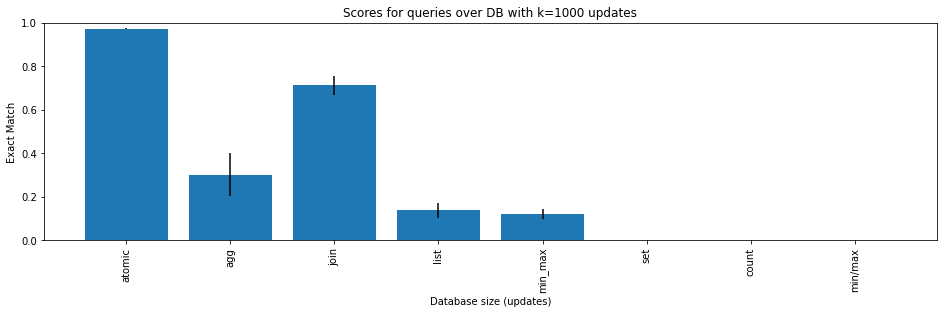

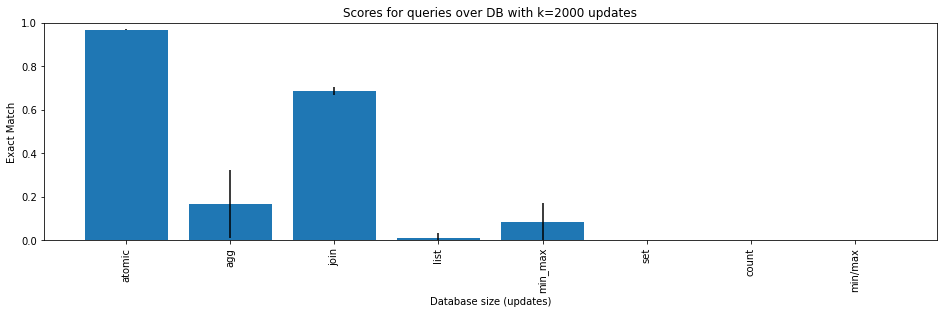

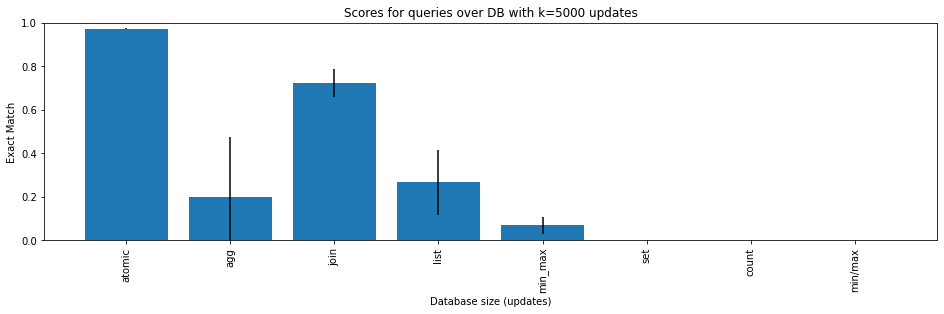

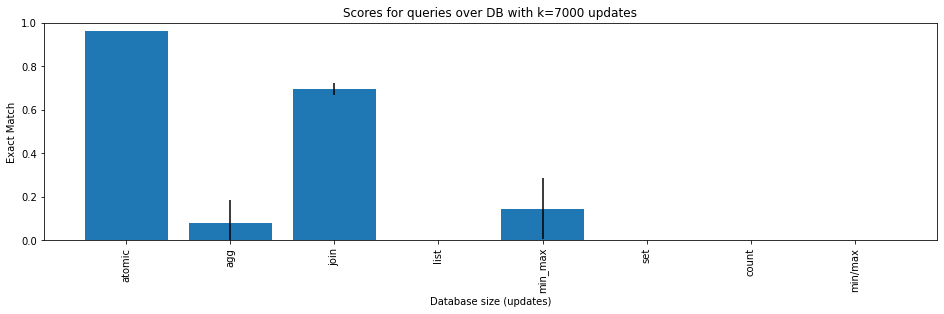

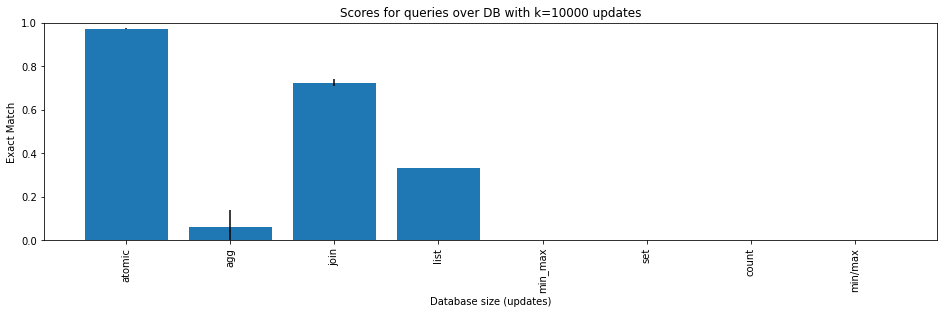

In [103]:
data_sizes = [50,100,500,1000,2000,5000,7000,10000]


a=[]
for size in data_sizes:
    plt.figure(figsize=(16,4))
    plt.title("Scores for queries over DB with k={} updates".format(size))
    plt.xlabel("Database size (updates)")
    plt.ylabel("Exact Match")
    plt.xticks(rotation=90)
    plt.ylim(0,1)
    means = [breakdown[col]["mean"].T["t5-base"][1e-3].T['v0.4'].T[size] for col in query_cols]
    std = [breakdown[col]["std"].T["t5-base"][1e-3].T['v0.4'].T[size] for col in query_cols]

    plt.bar([col.replace("query_","") for col in query_cols],means,yerr=std)



    plt.show()

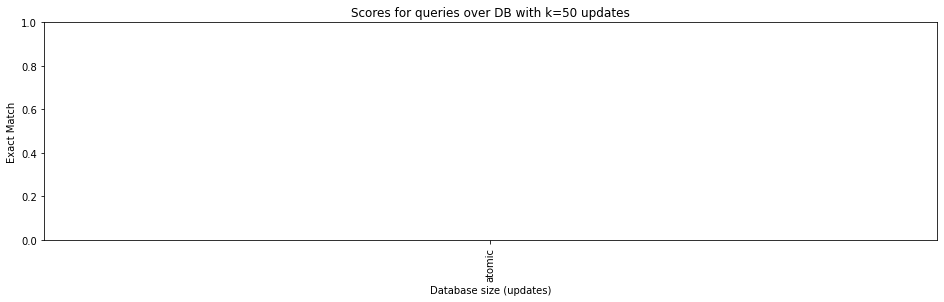

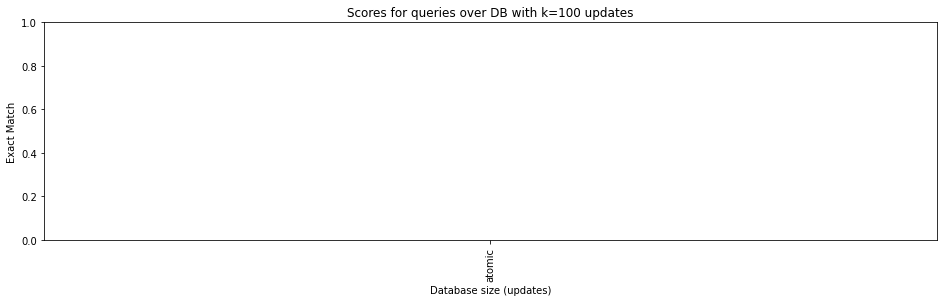

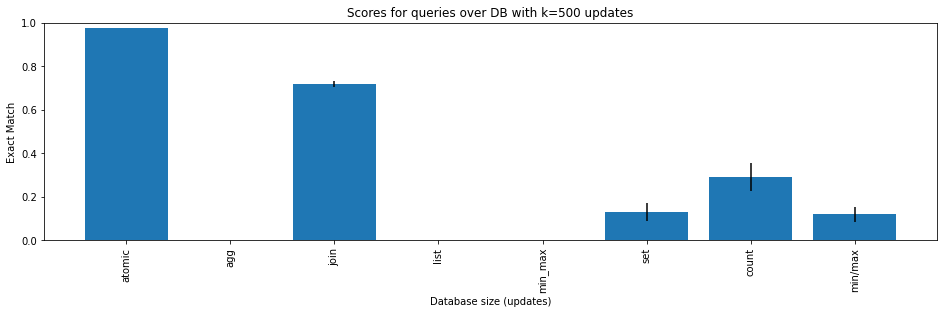

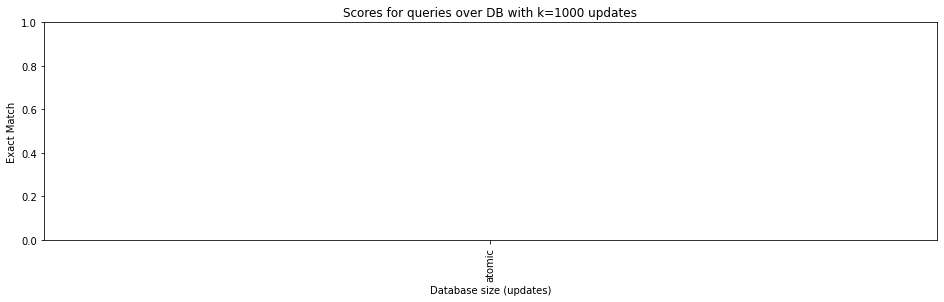

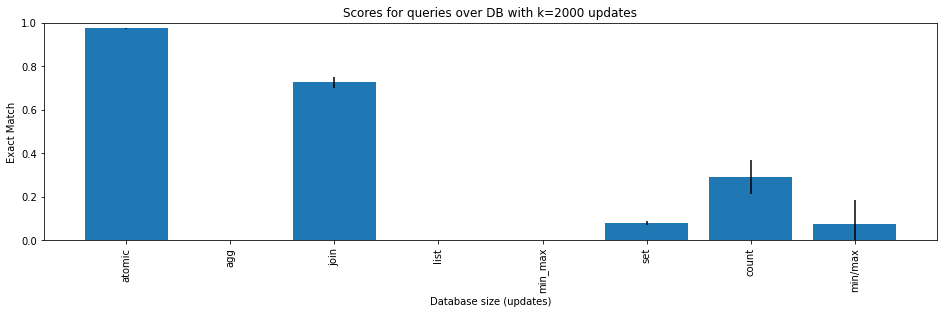

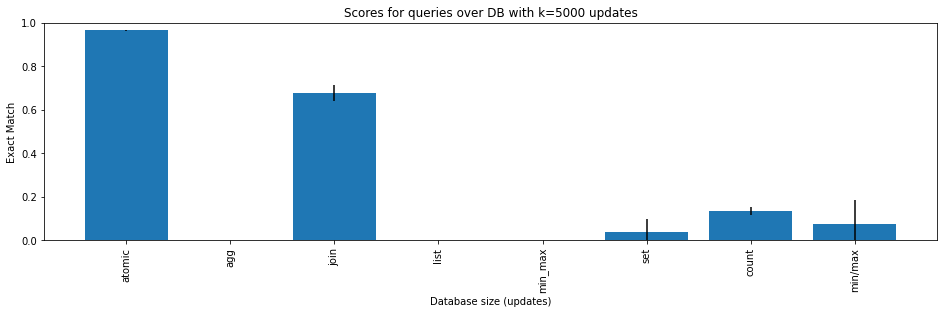

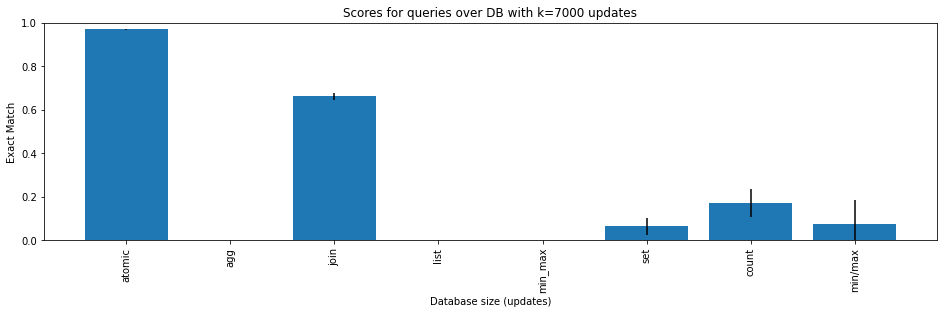

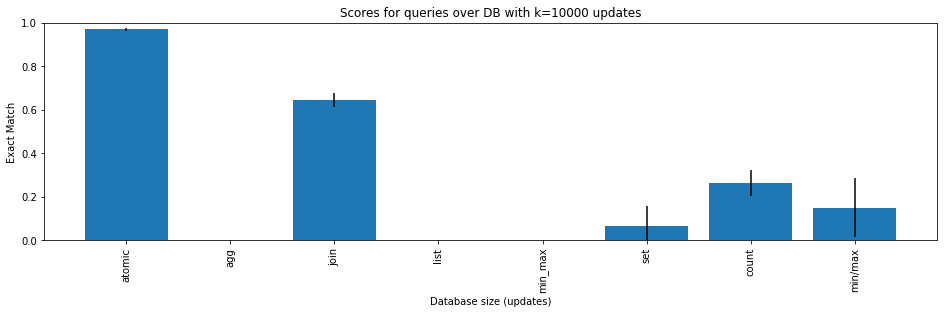

In [104]:

data_sizes = [50,100,500,1000,2000,5000,7000,10000]


a=[]
for size in data_sizes:
    plt.figure(figsize=(16,4))
    plt.title("Scores for queries over DB with k={} updates".format(size))
    plt.xlabel("Database size (updates)")
    plt.ylabel("Exact Match")
    plt.xticks(rotation=90)
    plt.ylim(0,1)
    means = [breakdown[col]["mean"].T["t5-base"][1e-3].T['v0.5'].T[size] for col in query_cols]
    std = [breakdown[col]["std"].T["t5-base"][1e-3].T['v0.5'].T[size] for col in query_cols]

    plt.bar([col.replace("query_","") for col in query_cols],means,yerr=std)



    plt.show()


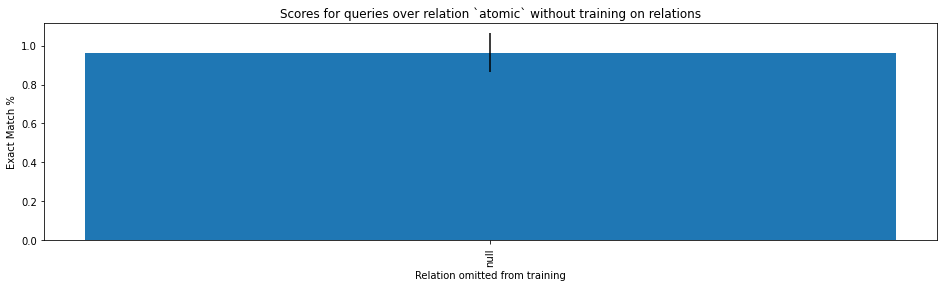

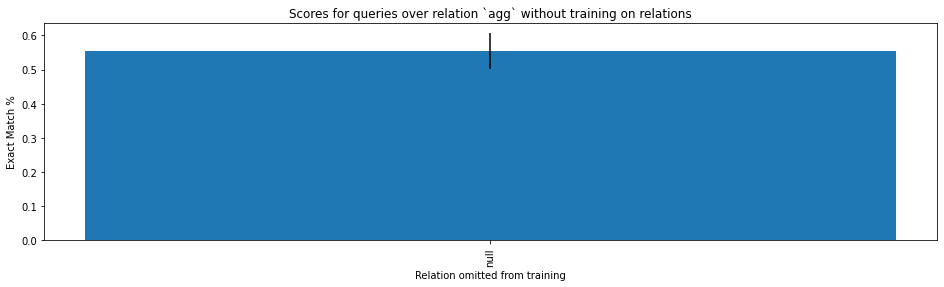

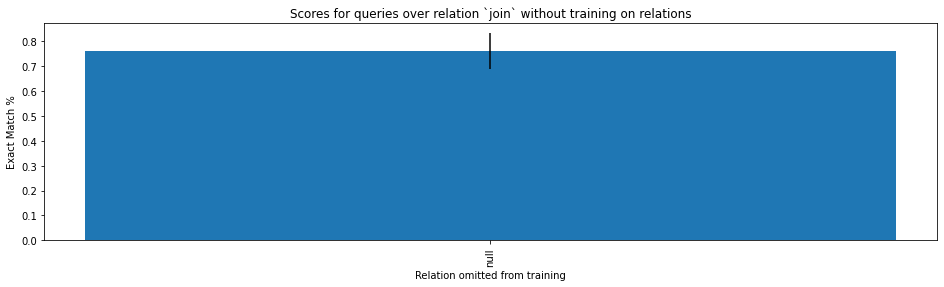

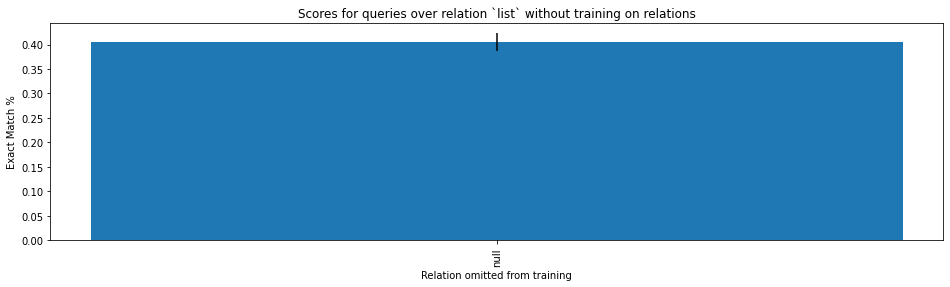

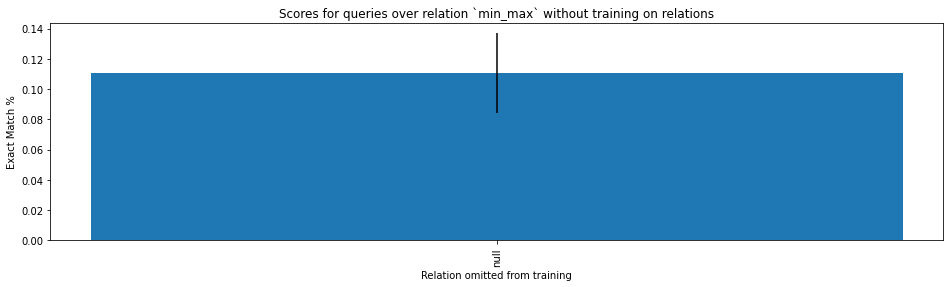

In [25]:
for col in breakdown_cols:
    means = breakdown[col]["mean"].T["t5-base"]["50"]
    std = breakdown[col]["std"].T["t5-base"]["50"]
    plt.figure(figsize=(16,4))
    plt.xticks(rotation=90)

    plt.title("Scores for queries over relation `{}` without training on relations".format(col.replace("breakdown_","")))
    plt.xlabel("Relation omitted from training")
    plt.ylabel("Exact Match %")
    plt.bar([i.replace('.',' and ') for i in means.index], means, yerr=std)
    plt.show()